In [28]:
import sys
import torch
import torch.nn as nn
from torchsummary import summary

from models.common import Conv

sys.path.insert(0, "/home/nguyen.thanh.huyenb/yolov7/yolov7_train")

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
import random
random.random()

0.30720599289696926

In [3]:
import models

In [ ]:
from models.common import *

In [8]:
tmp = [torch.rand(2,3,4), torch.rand(2,3,4)]
torch.cat(tmp, 1).shape

torch.Size([2, 6, 4])

In [52]:
w = "/home/nguyen.thanh.huyenb/yolov7/yolov7_train/runs/train/yolov7-qat-/weights/best.pt"
ckpt = torch.load(w, map_location="cpu")  
model = ckpt['model'].float().fuse().eval()

for m in model.modules():
    if type(m) in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
        m.inplace = True  # pytorch 1.7.0 compatibility
    elif type(m) is nn.Upsample:
        m.recompute_scale_factor = None  # torch 1.11.0 compatibility
    elif type(m) is Conv:
        m._non_persistent_buffers_set = set()  # pytorch 1.6.0 compatibility

model.to(device)
tmp = torch.rand(1,3,224,320)
pred = model(tmp)[0]
pred[0].shape
# summary(model,(3,224,320))

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


torch.Size([4410, 13])

In [39]:
anchors =[ [12,16, 19,36, 40,28] , # P3/8
 [36,75, 76,55, 72,146] , # P4/16
   [142,110, 192,243, 459,401]]
na = (
        (len(anchors[0]) // 2) if isinstance(anchors, list) else anchors
    ) 
na

3

In [67]:
from models.yolo import Model
cfg = "/home/nguyen.thanh.huyenb/yolov7/yolov7/cfg/training/yolov7.yaml"
model = Model(cfg).to(device)

In [68]:
tmp = torch.rand(1,3,224,320)
pred = model(tmp)
pred[0].shape,pred[1].shape,pred[2].shape

(torch.Size([1, 3, 28, 40, 6]),
 torch.Size([1, 3, 14, 20, 6]),
 torch.Size([1, 3, 7, 10, 6]))

In [65]:
for m in model.model:
    print(m.type)

models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Concat
models.common.Conv
models.common.MP
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Concat
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Concat
models.common.Conv
models.common.MP
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Concat
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Concat
models.common.Conv
models.common.MP
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Concat
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Conv
models.common.Concat
models.common.Conv
models.common.SPPCSPC
m

In [80]:
from models.yolo import Detect, IDetect, IAuxDetect, IBin
y, dt = [], []
x = torch.rand(1,3,224,320)
for m in model.model:
    print(m.type)
    print(x.shape)
    
    if m.f != -1:  # if not from previous layer
        print(m.f)
        x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers

    

    if model.traced:
        if isinstance(m, Detect) or isinstance(m, IDetect) or isinstance(m, IAuxDetect) or isinstance(m, IKeypoint):
            break

    x = m(x)  # run
    y.append(x)  # save output

models.common.Conv
torch.Size([1, 3, 224, 320])
models.common.Conv
torch.Size([1, 32, 224, 320])
models.common.Conv
torch.Size([1, 64, 112, 160])
models.common.Conv
torch.Size([1, 64, 112, 160])
models.common.Conv
torch.Size([1, 128, 56, 80])
models.common.Conv
torch.Size([1, 64, 56, 80])
-2
models.common.Conv
torch.Size([1, 64, 56, 80])
models.common.Conv
torch.Size([1, 64, 56, 80])
models.common.Conv
torch.Size([1, 64, 56, 80])
models.common.Conv
torch.Size([1, 64, 56, 80])
models.common.Concat
torch.Size([1, 64, 56, 80])
[-1, -3, -5, -6]
models.common.Conv
torch.Size([1, 256, 56, 80])
models.common.MP
torch.Size([1, 256, 56, 80])
models.common.Conv
torch.Size([1, 256, 28, 40])
models.common.Conv
torch.Size([1, 128, 28, 40])
-3
models.common.Conv
torch.Size([1, 128, 56, 80])
models.common.Concat
torch.Size([1, 128, 28, 40])
[-1, -3]
models.common.Conv
torch.Size([1, 256, 28, 40])
models.common.Conv
torch.Size([1, 128, 28, 40])
-2
models.common.Conv
torch.Size([1, 128, 28, 40])
models

In [84]:
y[101].shape, y[102].shape,  y[103].shape, y[104].shape

(torch.Size([1, 512, 7, 10]),
 torch.Size([1, 256, 28, 40]),
 torch.Size([1, 512, 14, 20]),
 torch.Size([1, 1024, 7, 10]))

In [87]:
tmp = [torch.rand([1, 256, 28, 40]), torch.rand([1, 512, 14, 20]), torch.rand(1, 1024, 7, 10)]
model.model[-1](tmp)

[tensor([[[[[-4.36169e-01, -2.40432e-02,  3.36361e-01,  7.28853e-01, -6.45423e+00,  4.11381e+00],
            [-2.91352e-01,  4.68531e-01,  2.88126e-01,  6.80083e-01, -6.38345e+00,  4.17853e+00],
            [ 2.89332e-02,  4.10279e-01,  4.27913e-01,  4.98962e-01, -5.95887e+00,  4.29415e+00],
            ...,
            [ 8.29934e-02,  3.26430e-01, -6.98975e-03,  9.50023e-01, -6.44379e+00,  4.90202e+00],
            [-2.73865e-01, -1.74293e-01,  4.42356e-01,  2.67237e-01, -6.34218e+00,  4.56361e+00],
            [-1.78315e-01,  1.27939e-01,  4.83686e-01,  6.58294e-01, -6.36917e+00,  4.24459e+00]],
 
           [[-3.79304e-02,  1.77922e-01,  4.84464e-01,  5.19817e-01, -6.15820e+00,  4.27717e+00],
            [-1.49070e-01, -2.72987e-02,  6.59311e-02,  4.72969e-01, -6.12555e+00,  4.36457e+00],
            [ 2.43428e-02,  2.68925e-02,  7.73299e-02,  5.08962e-01, -6.63341e+00,  4.68850e+00],
            ...,
            [ 7.16600e-03, -1.25201e-01,  7.18113e-02,  5.46189e-01, -6.39435e+00

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import scipy
import cv2

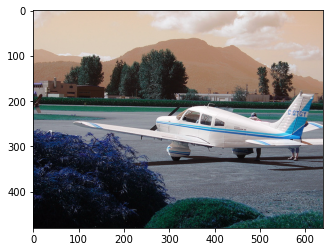

In [42]:
img = Image.open("/home/nguyen.thanh.huyenb/yolov7/training_minicoco_dataset/test/images/000000104724.jpg")
img = cv2.imread("/home/nguyen.thanh.huyenb/yolov7/training_minicoco_dataset/test/images/000000104724.jpg")

plt.imshow(img)

(480, 640, 3)
480 640
(4.3, 4.3, 1)
112 149 256 51
(480, 640, 3)


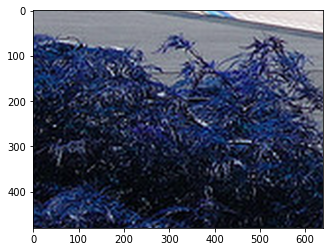

In [87]:
import numpy as np
from scipy.ndimage import zoom
def clipped_zoom(img, zoom_factor=1.5, **kwargs):

    h, w = img.shape[:2]
    print(h, w)

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    print(zoom_tuple)

    # Bounding box of the zoomed-in region within the input array
    zh = int(np.round(h / zoom_factor))
    zw = int(np.round(w / zoom_factor))
    top = (h - zh) // 2
    left = (w - zw) // 2
    top = random.randint(0, h - zh)
    left = random.randint(0, w - zw)

    print(zh, zw, top, left)
   
    out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

    # `out` might still be slightly larger than `img` due to rounding, so
    # trim off any extra pixels at the edges
    trim_top = ((out.shape[0] - h) // 2)
    trim_left = ((out.shape[1] - w) // 2)
    out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    return out

labels = [[1, 50,100,200,200]]
print(img.shape)
zm1 = clipped_zoom(img,4.3)
print(zm1.shape)
plt.imshow(zm1)

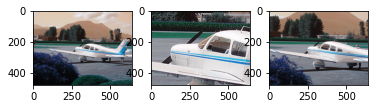

In [22]:
zm1 = clipped_zoom(img, 4)
zm2 = clipped_zoom(img, 1.5)


fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[1].imshow(zm1)
ax[2].imshow(zm2)

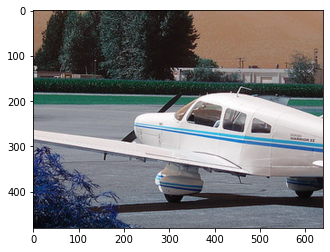

(480, 640, 3)
0.7445758184227125 0.2678098897858481
(480, 640, 3)
[[ 87.22879092 126.78098898 348.91516368 253.56197796]]


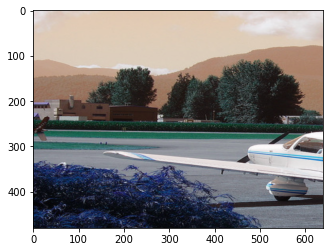

In [183]:
def bbox_area(bbox):
    return abs(bbox[:, 2] - bbox[:, 0]) * abs(bbox[:,3] - bbox[:,1])
def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    
    Parameters
    ----------
    
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]


    return bbox

def scale_zoom_in(img, bboxes):
    img_shape = img.shape
    scale = 1.4
    scale = (max(-1, -scale), scale)
    scale_x = random.uniform(*scale)
    scale_y = random.uniform(*scale)
    scale_x = random.uniform(0, 1)
    scale_y = random.uniform(0, 1)
    print(scale_x, scale_y)
	
		

    resize_scale_x = 1 + scale_x
    resize_scale_y = 1 + scale_y

    img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
    
    bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]



    canvas = np.zeros(img_shape, dtype = np.uint8)

    y_lim = int(min(resize_scale_y,1)*img_shape[0])
    x_lim = int(min(resize_scale_x,1)*img_shape[1])


    canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]

    img = canvas
    bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)


    return img, bboxes

# img = Image.open("/home/nguyen.thanh.huyenb/yolov7/training_minicoco_dataset/test/images/000000104724.jpg")
img = cv2.imread("/home/nguyen.thanh.huyenb/yolov7/training_minicoco_dataset/test/images/000000104724.jpg")
# img = cv2.imread("/home/nguyen.thanh.huyenb/yolov7/training_minicoco_dataset/test/images/000000400554.jpg")
print(img.shape)
h, w = img.shape[:2]
labels = np.array([[3 ,0.573125, 0.533635, 0.846937 ,0.326521]]) * [w,h,w,h]
zm1, bboxes = scale_zoom_in(img, labels)
print(zm1.shape)
print(bboxes)
plt.imshow(zm1)

In [94]:
random.uniform(0,1)

0.5000114228566386